In [1]:
import jax.numpy as jnp
from jax import tree_util as jtu, vmap, jit
from jax.experimental import sparse
from pymdp.agent import Agent
import matplotlib.pyplot as plt
import seaborn as sns

from pymdp.inference import smoothing_ovf

/home/conor/Documents/ml_at_verses/pymdp_dev/pymdp/pymdp/agent.py:706: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (


Set up generative model and a sequence of observations. The A tensors, B tensors and observations are specified in such a way that  only later observations ($o_{t > 1}$) help disambiguate hidden states at earlier time points. This will demonstrate the importance of "smoothing" or retrospective inference

In [2]:
num_states = [3, 2]
num_obs = [2]
n_batch = 2

A_1 = jnp.array([[1.0, 1.0, 1.0], [0.0,  0.0,  1.]])
A_2 = jnp.array([[1.0, 1.0], [1., 0.]])

A_tensor = A_1[..., None] * A_2[:, None]

A_tensor /= A_tensor.sum(0)

A = [jnp.broadcast_to(A_tensor, (n_batch, num_obs[0], 3, 2)) ]

# create two transition matrices, one for each state factor
B_1 = jnp.broadcast_to(
    jnp.array([[0.0, 1.0, 0.0], [0.0, 0.0, 1.0], [1.0, 0.0, 0.0]]), (n_batch, 3, 3)
)

B_2 = jnp.broadcast_to(
        jnp.array([[0.0, 1.0], [1.0, 0.0]]), (n_batch, 2, 2)
    )

B = [B_1[..., None], B_2[..., None]]

# for the single modality, a sequence over time of observations (one hot vectors)
obs = [jnp.broadcast_to(jnp.array([[1., 0.], # observation 0 is ambiguous with respect state factors
                                    [1., 0], # observation 0 is ambiguous with respect state factors
                                    [1., 0], # observation 0 is ambiguous with respect state factors
                                    [0., 1.]])[:, None], (4, n_batch, num_obs[0]) )] # observation 1 provides information about exact state of both factors 
C = [jnp.zeros((n_batch, num_obs[0]))] # flat preferences
D = [jnp.ones((n_batch, 3)) / 3., jnp.ones((n_batch, 2)) / 2.] # flat prior
E = jnp.ones((n_batch, 1))

Construct the `Agent`

In [3]:
pA = None
pB = None

agents = Agent(
        A=A,
        B=B,
        C=C,
        D=D,
        E=E,
        pA=pA,
        pB=pB,
        policy_len=3,
        onehot_obs=True,
        action_selection="deterministic",
        sampling_mode="full",
        inference_algo="ovf",
        num_iter=16,
        batch_size=n_batch
)

### OVF Smoothing

Using `obs` and `policies`, pass in the arguments `outcomes`, `past_actions`, `empirical_prior` and `qs_hist` to `agent.infer_states(...)`

Run first timestep of inference using `obs[0]`, no past actions, empirical prior set to actual prior, no qs_hist

In [4]:
prior = agents.D
action_hist = []
qs_hist=None
for t in range(len(obs[0])):
    first_obs = jtu.tree_map(lambda x: jnp.moveaxis(x[:t+1], 0, 1), obs)
    beliefs = agents.infer_states(first_obs, prior, qs_hist=qs_hist)
    actions = jnp.broadcast_to(agents.policies[0, 0], (2, 2))
    prior, qs_hist = agents.update_empirical_prior(actions, beliefs)
    if t < len(obs[0]) - 1:
        action_hist.append(actions)

v_jso = jit(vmap(smoothing_ovf), backend='cpu')
actions_seq = jnp.stack(action_hist, 1)

In [5]:
smoothed_beliefs = v_jso(beliefs, agents.B, actions_seq)
%timeit v_jso(beliefs, agents.B, actions_seq)[0][0].block_until_ready()

2.04 ms ± 333 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Try the version of `smoothing_ovf` with sparse tensors


In [6]:
sparse_B = jtu.tree_map(lambda b: sparse.BCOO.fromdense(b, n_batch=1), agents.B)

smoothed_beliefs_sparse = v_jso(beliefs, sparse_B, actions_seq)
%timeit v_jso(beliefs, sparse_B, actions_seq)[0][0].block_until_ready()

1.95 ms ± 68.2 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Now we can plot that pair of filtering / smoothing distributions for the single batch / single agent, that we ran

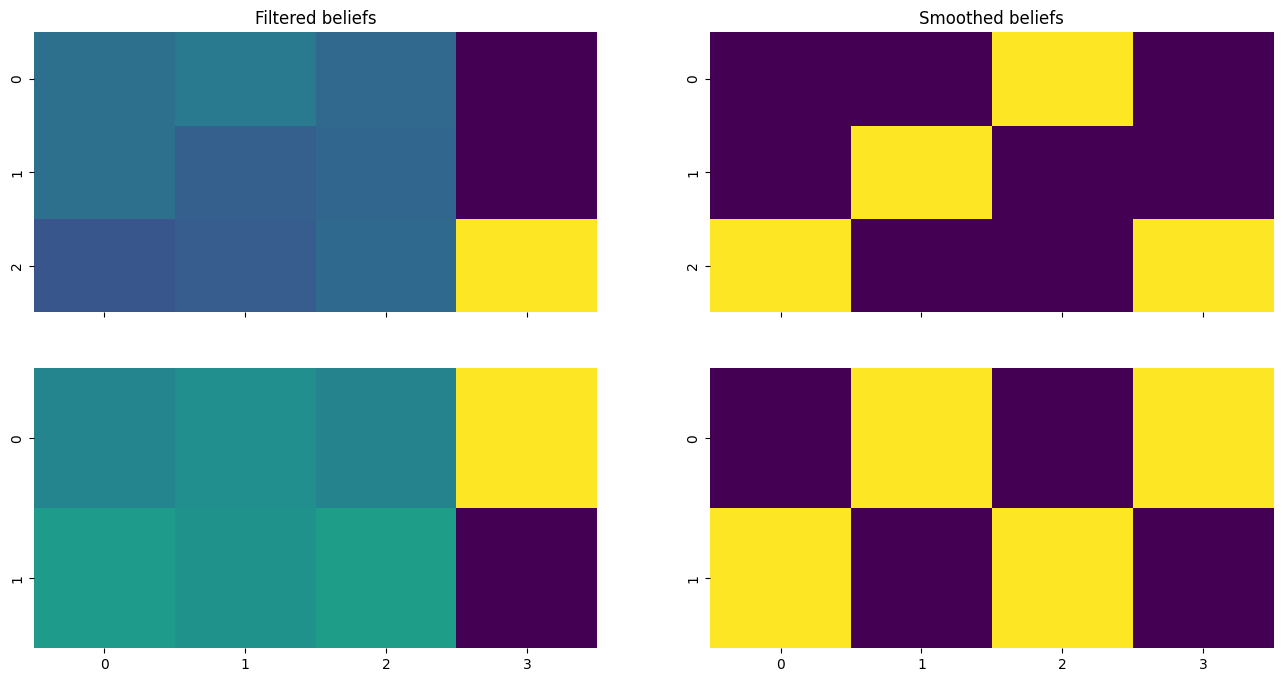

In [7]:
# with dense matrices
fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=True)

sns.heatmap(beliefs[0][0].mT, ax=axes[0, 0], cbar=False, vmax=1., vmin=0., cmap='viridis')
sns.heatmap(beliefs[1][0].mT, ax=axes[1, 0], cbar=False, vmax=1., vmin=0., cmap='viridis')

sns.heatmap(smoothed_beliefs[0][0][0].mT, ax=axes[0, 1], cbar=False, vmax=1., vmin=0., cmap='viridis')
sns.heatmap(smoothed_beliefs[0][1][0].mT, ax=axes[1, 1], cbar=False, vmax=1., vmin=0., cmap='viridis')

axes[0, 0].set_title('Filtered beliefs')
axes[0, 1].set_title('Smoothed beliefs')
plt.show()

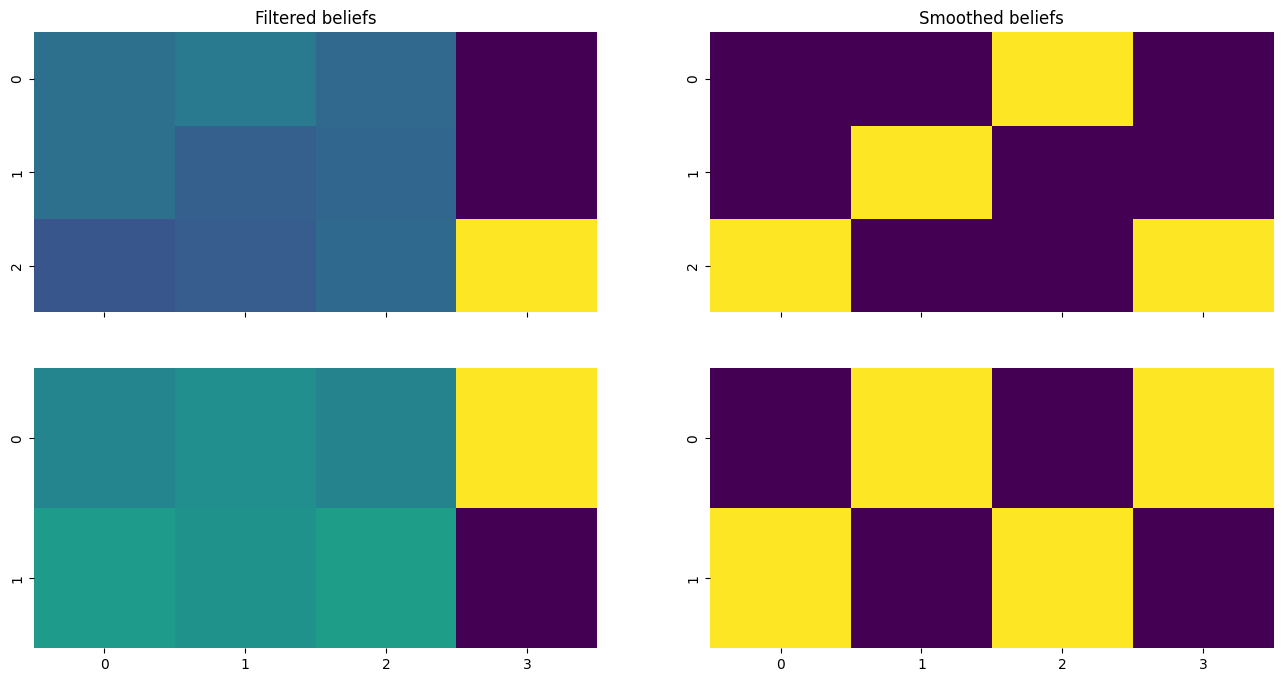

In [8]:
# with sparse matrices
fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=True)

sns.heatmap(beliefs[0][0].mT, ax=axes[0, 0], cbar=False, vmax=1., vmin=0., cmap='viridis')
sns.heatmap(beliefs[1][0].mT, ax=axes[1, 0], cbar=False, vmax=1., vmin=0., cmap='viridis')

sns.heatmap(smoothed_beliefs_sparse[0][0][0].mT, ax=axes[0, 1], cbar=False, vmax=1., vmin=0., cmap='viridis')
sns.heatmap(smoothed_beliefs_sparse[0][1][0].mT, ax=axes[1, 1], cbar=False, vmax=1., vmin=0., cmap='viridis')

axes[0, 0].set_title('Filtered beliefs')
axes[0, 1].set_title("Smoothed beliefs")
plt.show()

### Compare to marginal message passing

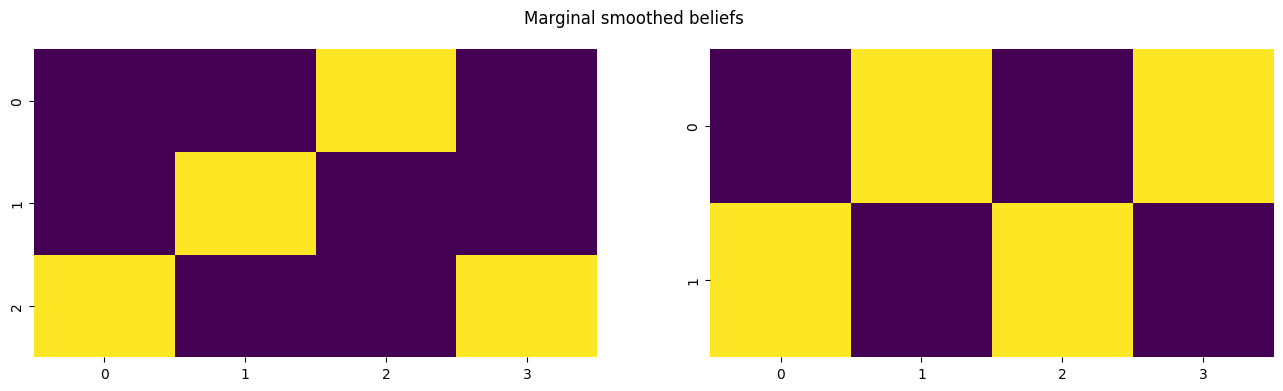

In [9]:
mmp_agents = agents = Agent(
        A=A,
        B=B,
        C=C,
        D=D,
        E=E,
        pA=pA,
        pB=pB,
        policy_len=3,
        control_fac_idx=None,
        onehot_obs=True,
        action_selection="deterministic",
        sampling_mode="full",
        inference_algo="mmp",
        num_iter=16,
        batch_size=n_batch,
)

mmp_obs = [jnp.moveaxis(obs[0], 0, 1)]
post_marg_beliefs = mmp_agents.infer_states(mmp_obs, mmp_agents.D, past_actions=jnp.stack(action_hist, 1))

#with sparse matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 4), sharex=True)

sns.heatmap(post_marg_beliefs[0][0].mT, ax=axes[0], cbar=False, vmax=1., vmin=0., cmap='viridis')
sns.heatmap(post_marg_beliefs[1][0].mT, ax=axes[1], cbar=False, vmax=1., vmin=0., cmap='viridis')

fig.suptitle('Marginal smoothed beliefs');

### Compare to variational message passing

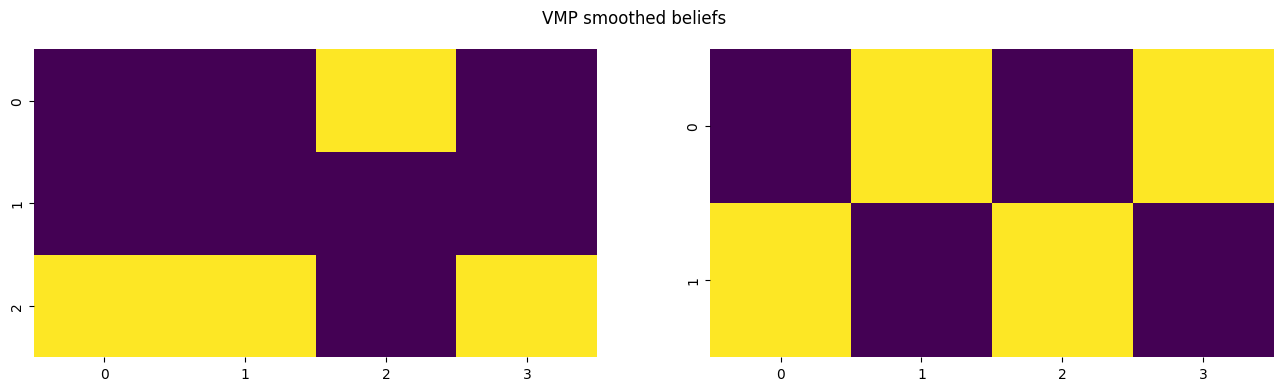

In [ ]:
vmp_agents = agents = Agent(
        A=A,
        B=B,
        C=C,
        D=D,
        E=E,
        pA=pA,
        pB=pB,
        policy_len=3,
        control_fac_idx=None,
        onehot_obs=True,
        action_selection="deterministic",
        sampling_mode="full",
        inference_algo="vmp",
        num_iter=16,
        batch_size=n_batch,
)

vmp_obs = [jnp.moveaxis(obs[0], 0, 1)]
post_vmp_beliefs = vmp_agents.infer_states(vmp_obs, vmp_agents.D, past_actions=jnp.stack(action_hist, 1))

#with sparse matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 4), sharex=True)

sns.heatmap(post_vmp_beliefs[0][0].mT, ax=axes[0], cbar=False, vmax=1., vmin=0., cmap='viridis')
sns.heatmap(post_vmp_beliefs[1][0].mT, ax=axes[1], cbar=False, vmax=1., vmin=0., cmap='viridis')

fig.suptitle('VMP smoothed beliefs')